In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = [10, 2, 3]
y = [5, 1, 7]
df = pd.DataFrame([x, y]).T
df.columns = ['x', 'y']
df

,x,y
0,10,5
1,2,1
2,3,7


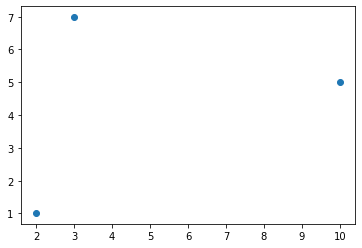

In [3]:
plt.scatter(df['x'], df['y'])

In [4]:
# Initial Centroids
x_cord = [3, 6, 4]
y_cord = [4, 3, 6]
centroids = pd.DataFrame([x_cord, y_cord]).T

In [5]:
# Intial Labels : hard assignment
##  Cal distance from each centroid to all data and choose closest as label
from scipy.spatial import distance
dist = distance.cdist(df.values,centroids.values)
labels = np.argmin(dist, axis = 1)

## E Step : Estimate the cluster reponsibility from cluster params

In [6]:
## Replacing the labels above into fractions with each cluster
## We know the cluster weight (relative representation of cluster in data), mean vector(centroid) & covariance matrix (spread of data)
from scipy.stats import multivariate_normal
cluster_weight = 1/3 # Initial weight, will be updated

likelihood = np.zeros(shape = (3,3))
for index, data in enumerate(df.values):
    likelihood_data = []
    for cent_val in centroids.values:
        likelihood_ind = cluster_weight*multivariate_normal.pdf(data, mean = cent_val, cov=[[3, 0], [0, 3]])
        likelihood_data.append(likelihood_ind)
    likelihood[index] = likelihood_data/np.sum(likelihood_data)
likelihood_df = pd.DataFrame(likelihood, columns=['ClusterA', 'ClusterB', 'ClusterC'])
likelihood_df

## Likelihood along rows sum to 1 : indicates the data point share among clusters. Ex: Data 0 has highest share with cluster B

## Likelihood along columns may > 1, indicates the total data points in the cluster (decimals though!)

,ClusterA,ClusterB,ClusterC
0,0.006323,0.938479,0.055198
1,0.812335,0.153430,0.034235
2,0.233604,0.016232,0.750165


## M Step : Estimate the cluster parameters given responsibilites

In [7]:
# Revise the params : update the initial guess

## 1. Cluster Weights
## Updating the weight, initially we had given equal share, but based on analysis the weights will be inc or dec. If inc it means that cluster is closer to more data. 
## Result indicate the cluster A and B are larger than avg size.
cluster_weight = np.sum(likelihood_df, axis = 0)/3
cluster_weight


## 2. Cluster Means
### Ideally we want the mean to move closer to like center of mass. In likelihood_df, the proportional of each data is available.a
cluster_mean = np.zeros(shape = (3,2))
for index, clusters in enumerate(likelihood_df.columns):
    cluster_mean[index] = np.dot(likelihood_df[clusters],df.values)/likelihood_df[clusters].sum()
cluster_mean_df = pd.DataFrame(cluster_mean, columns = ['X','Y'])
print("## Cluster Mean ##")
print(cluster_mean_df)

## 3. Covariances
variance = []
for i, data in enumerate(df.values):
    var = np.array(df.values - cluster_mean_df.loc[i].values)
    b = np.zeros(shape = (2,2))
    for index, value in enumerate(var):
        a = np.dot(value.reshape(-1, 1), value.reshape(1, -1))
        cluster = likelihood_df.columns[i]
        b += likelihood_df[cluster][index]*a
    variance_local = np.round(b/likelihood_df[clusters].sum(), 2)
    variance.append(variance_local)
print("## Cluster Variance ##")
variance = pd.DataFrame([variance], columns=['ClusterA', 'ClusterB', 'ClusterC'])
variance

## Cluster Mean ##
          X         Y
0  2.270076  2.356046
1  8.789808  4.475466
2  3.419428  6.623861
## Cluster Variance ##


,ClusterA,ClusterB,ClusterC
0,"[[0.67, 1.45], [1.45, 7.83]]","[[10.71, 4.74], [4.74, 2.64]]","[[3.09, -0.52], [-0.52, 1.59]]"
